# Preprocessing step 2
- Add AD sequence features
- Fix names of some ADs that were incorrect in design
- Calculate which ADs are significantly different from WT
- Fix names and P65_L2Y indicies

In [1]:
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna 
import pandas as pd
import numpy as np
import itertools
import re
import matplotlib.pyplot as plt
from collections import defaultdict 
import scipy
from scipy import stats
import glob
import warnings
warnings.filterwarnings('ignore')
import os
import operator
import logomaker
import matplotlib

import statsmodels
from pandas.tools.plotting import scatter_matrix
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import StableAnalaysisFunctions
import pickle

import matplotlib.patches as mpatches
from localcider.sequenceParameters import SequenceParameters
import localcider
from statsmodels.formula.api import ols
import statsmodels.api as sm
lowess = sm.nonparametric.lowess
from statsmodels.stats.anova import anova_lm
from statsmodels.graphics.factorplots import interaction_plot
lightblue , darkblue, lightgreen, darkgreen, pink =  '#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99'
import matplotlib.patches as mpatches
from matplotlib.patches import Polygon
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
ADCoordinates={ 'CITED2_N':[220,258],# isoform 1
               'Hif1-AD2_46':[781,896],# isoform 1
               'vp16N_C':[415,453], #from blast
               'stat3':[719,764],# isoform 1
               'p65':[521,551],# isoform 1
              'p65_L2Y':[519,551]}
ActivityMeasurements = ['MSS18_Sort_1_Activity',
 'MSS18_Sort_2_Activity',
 'MSS18_Sort_3_Activity',
 'MSS18_Sort_4R_Activity']

In [3]:
## Library Design DF
masterDF = pd.read_pickle('../AnalysisSuportFiles/Pickle_ExpDesignDF_unique_20200218')
PreMerged_AD_DF = pd.read_pickle('../Preprocessing/pickleFiles/NormalizedData/MSS18_AD_DF_FluorValues_NextSeq20210722_NormToNoAD')


ColstoAdd=PreMerged_AD_DF.columns[1:]#[<list of columns you want to add>]
for col in ColstoAdd:
    tempDict =dict(zip(PreMerged_AD_DF['ADseq'],PreMerged_AD_DF[col]))#make a dictionary related ADseq to value you want to add to the DF
    tempSeries = masterDF['ADseq'] #temportary Series
    temp = tempSeries.replace(tempDict) #This replace command takes a dictionary and replaces everything in that column with the dictionary entry.
    masterDF[col] = temp # add column to new DF

summaryCols = [ 'MutName','HandDesigned', u'WT','CITED2_N', 'stat3', 'Hif1-AD2_46','p65_L2Y', 'p65', 'vp16N_C', u'ADseq','Activity_Mean_MSS18']

# make a new column with shorter mutant names to correct for a few that have very long names and don't plot well
names = masterDF.MutName
masterDF['shortname']=names.str.split(',').str[0]

#columns to focus on for plotting
currentItem ='Activity_Mean_MSS18'
currentSEM  ='Activity_SEM_MSS18'

# Useful plotting variables
maxActivity = max(masterDF[currentItem])*1.1
minActivity = min(masterDF[currentItem])*.9

## support variables
ADlist = [ 'CITED2_N','Hif1-AD2_46','vp16N_C','stat3','p65']
ExtendedADlist = [ 'CITED2_N','Hif1-AD2_46','vp16N_C','stat3','p65','p65_L2Y']


# tempDF2 = masterDF.sort_values(by='MutName')
## add extra columns with sums of more AA counts
masterDF['CountFYWL']=masterDF.Aromatics+masterDF.CountL


In [4]:
## build a WT DF
WTDF = pd.read_pickle('../../../ArrayDesign/Array3_strongAcidicADs/Pickle_WT_DF_AcidBlobs_LC2')
WTname2seqDict = dict(zip(WTDF.ADname,WTDF.ADseq))
WTseq2nameDict =dict(zip(WTDF.ADseq,WTDF.ADname))
# WTname2currentItemDict = dict(zip(WTDF.ADname,WTDF[currentItem]))
WTADset = set(WTDF.ADname)
print WTDF
# for i, entry in WTDF.iterrows():
indx = masterDF.WT
WTDF=masterDF[indx]
WTname2currentItemDict_holder,WTname2currentSEMDict_holder = {},{}

for value in [['Activity_Mean_MSS18','Activity_SEM_MSS18'],['Zscore_Mean_MSS18','Zscore_SEM_MSS18']]:
    WTname2currentItemDict,WTname2currentSEMDict = {},{}
    for ad in WTseq2nameDict.keys():
        temp = WTDF[WTDF.ADseq==ad]
        temp2 =temp[value[0]].values
        WTname2currentItemDict[WTseq2nameDict[ad]]=temp2[0]
        temp2 =temp[value[1]].values
        WTname2currentSEMDict[WTseq2nameDict[ad]]=temp2[0]
    WTname2currentItemDict_holder[value[0]]=WTname2currentItemDict
    WTname2currentSEMDict_holder[value[0]]=WTname2currentSEMDict
listofDictstoSave = [WTname2seqDict,WTseq2nameDict,WTname2currentItemDict_holder,WTname2currentSEMDict_holder]
f = open('pickleFiles/WTDictionaries','w')
pickle.dump(listofDictstoSave, f)
f.close()

WTname2currentItemDict = WTname2currentItemDict_holder[currentItem]


                                            ADseq       ADname MutType MutName
0         PTDVSLGDELHLDGEDVAMAHADALDDFDLDMLGDGDSP      vp16N_C      WT    none
1                 PGLPNGLLSGDEDFSSIADMDFSALLSQISS          p65      WT    none
2  SNTIDLPMSPRTLDSLMQFGNNGEGAEPSAGGQFESLTFDMELTSE        stat3      WT    none
3         TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTD     CITED2_N      WT    none
4  RLLGQSMDESGLPQLTSYDCEVNAPIQGSRNLLQGEELLRALDQVN  Hif1-AD2_46      WT    none


In [7]:
# determine which ADs are statistically significantly different from WT.

print 'Using the normalization to No AD'

IndepBioReplicates=[
    'MSS18_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed_NormToNoAD',
 'MSS18_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed_NormToNoAD',
 'MSS18_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed_NormToNoAD',
 'MSS18_Sort_4AvgADActivityOutliersRemovedAndBCsCollapsed_NormToNoAD',                   ]

UncorrectedPvalues =[]
for i, entry in masterDF.iterrows():
    tempVals =np.array(list(entry[IndepBioReplicates].values)) # pull out all the BioRep measuremnts
    # find the right WT 
    for ad in ExtendedADlist:
        if entry[ad]==1:
            if ad =='p65_L2Y':
                tempWT = WTDF[WTDF['p65']==1]
            else:
                tempWT = WTDF[WTDF[ad]==1]
            tempWTmeasurements = tempWT[IndepBioReplicates].values
    stat = scipy.stats.ttest_ind(tempWTmeasurements[0],tempVals)
    UncorrectedPvalues.append(stat[1])

masterDF['UncorrectedPvalues'] = UncorrectedPvalues

# correct for multiple hypothesis testing--separately for each AD
ttestvsWT_dict,correctedpvalsDict =defaultdict(), defaultdict()
for ad in ADlist:
    #pull out the variants of that AD
    indx = (masterDF[ad]==1)
    tempDF = masterDF[indx]
    reject, pvals_corrected,extra1, exra2 = statsmodels.stats.multitest.multipletests(tempDF.UncorrectedPvalues,method='fdr_bh')
    tempDict = dict(zip(tempDF.ADseq,reject))
    ttestvsWT_dict.update(tempDict)
    tempDict = dict(zip(tempDF.ADseq,pvals_corrected))
    correctedpvalsDict.update(tempDict)
    print '%s\t %i sig diff % i total' % (ad,sum(reject),sum(indx))
tempSeries = masterDF['ADseq']
masterDF['SigDiff_NormToNoAD'] = tempSeries.replace(ttestvsWT_dict)
masterDF['CorrectedPvalues'] = tempSeries.replace(correctedpvalsDict)


Using the normalization to No AD
CITED2_N	 41 sig diff  117 total
Hif1-AD2_46	 9 sig diff  112 total
vp16N_C	 37 sig diff  73 total
stat3	 0 sig diff  111 total
p65	 0 sig diff  109 total


In [8]:
# use instead the Zscores
IndepBioReplicates =['MSS18_Sort_1AvgADActivityOutliersRemovedAndBCsCollapsed_Zscore','MSS18_Sort_2AvgADActivityOutliersRemovedAndBCsCollapsed_Zscore',
       'MSS18_Sort_3AvgADActivityOutliersRemovedAndBCsCollapsed_Zscore','MSS18_Sort_4AvgADActivityOutliersRemovedAndBCsCollapsed_Zscore']

print 'Using the Zscores'

UncorrectedPvalues =[]
for i, entry in masterDF.iterrows():
    tempVals =np.array(list(entry[IndepBioReplicates].values)) # pull out all the BioRep measuremnts
    # find the right WT 
    for ad in ExtendedADlist:
        if entry[ad]==1:
            if ad =='p65_L2Y':
                tempWT = WTDF[WTDF['p65']==1]
            else:
                tempWT = WTDF[WTDF[ad]==1]
            tempWTmeasurements = tempWT[IndepBioReplicates].values
    stat = scipy.stats.ttest_ind(tempWTmeasurements[0],tempVals)
    UncorrectedPvalues.append(stat[1])

masterDF['UncorrectedPvalues'] = UncorrectedPvalues

# correct for multiple hypothesis testing--separately for each AD
ttestvsWT_dict,correctedpvalsDict =defaultdict(), defaultdict()
for ad in ADlist:
    #pull out the variants of that AD
    indx = (masterDF[ad]==1)
    tempDF = masterDF[indx]
    reject, pvals_corrected,extra1, exra2 = statsmodels.stats.multitest.multipletests(tempDF.UncorrectedPvalues,method='fdr_bh')
    tempDict = dict(zip(tempDF.ADseq,reject))
    ttestvsWT_dict.update(tempDict)
    tempDict = dict(zip(tempDF.ADseq,pvals_corrected))
    correctedpvalsDict.update(tempDict)
    print '%s\t %i sig diff % i total' % (ad,sum(reject),sum(indx))
tempSeries = masterDF['ADseq']
masterDF['SigDiff_Zscore'] = tempSeries.replace(ttestvsWT_dict)
masterDF['CorrectedPvalues'] = tempSeries.replace(correctedpvalsDict)

Using the Zscores
CITED2_N	 50 sig diff  117 total
Hif1-AD2_46	 22 sig diff  112 total
vp16N_C	 42 sig diff  73 total
stat3	 0 sig diff  111 total
p65	 0 sig diff  109 total


# Which variants are only significantly different from WT in Z score space?


CITED2_N
41 ADs are significantly different from WT using the Normalization to No AD
50 ADs are significantly different from WT using the Zscore Normalization to No AD
40 ADs are significantly different from WT using both
WT activity is 4633.448213
                                            shortname  Activity_Mean_MSS18
ADseq                                                                     
EDFIDEEVLMELVIEMGLDRIKELPELWLGEEEFDFMED        STQN>E          5522.323440
TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEWDWMTD  F>Wmut20to39          5439.618472
TDAIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTD   F>Amut0to20          5187.713285
TDFIDEEYLMSLYIEMGLDRIKELPELWLGQNEFDFMTD           V>Y          5152.705894
TDFIDEEVLMSLVIEMGLDEIEELPELWLGQNEFDFMTD          RK>E          5096.616988
TDWIDEEVLMSLVIEMGLDRIKELPELWLGQNEFDFMTD   F>Wmut0to20          5086.386849
TDFIDEEVLFSLVIEFGLDRIKELPELWLGQNEFDFFTD           M>F          3915.530460
TDFIDEEVLMSLVIEMGLDRIKELPELWLGQNEADAATD    killmotif4          3260.630092
T

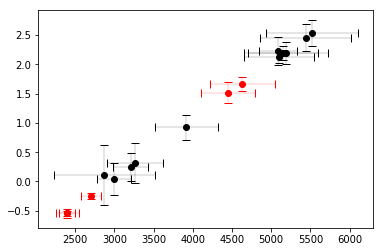

Hif1-AD2_46
9 ADs are significantly different from WT using the Normalization to No AD
22 ADs are significantly different from WT using the Zscore Normalization to No AD
8 ADs are significantly different from WT using both
WT activity is 2695.866145
                                                     shortname  \
ADseq                                                            
RLLGQSMDESGLPELTSYDCEVEAPIEGSRNLLQGEELLRALDQVN    QN>Emut7to29   
RLLGQSMDESGLPQLTSYDCEVNAPIQGSRELLEGEELLRALDEVE   QN>Emut29to46   
RLLGQSMDESGLPQLTSYDCEVNAPIQGSANLLQGEELLAALDQVN   RK>Amut29to46   
RLLGQSMDESGLPQLTSWDCEVNAPIQGSRNLLQGEELLRALDQVN             Y>W   
RLLGQSMDESGLPQLTSLDCEVNAPIQGSRNLLQGEELLRALDQVN             Y>L   
RLLGQSMDESGLPQLTSYDCEYNAPIQGSRNLLQGEELLRALDQYN             V>Y   
RLLGQSMDESGLPQLTSYDCEVNWPIQGSRNLLQGEELLRWLDQVN             A>W   
RLLGQSMDESGLPQLTSYDFEVNAPIQGSRNLLQGEELLEFLDQVN    superchargeA   
RLLGQSMDESGLPQLTSYDFEVNAPIQGSRNLLQGEELLRALDQVN            aro1   
RLLGQSMDESGLPQLTSYDCEVNA

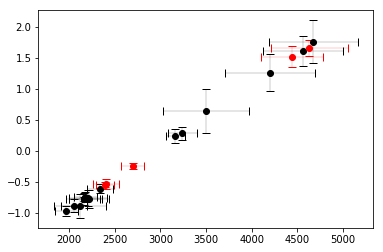

vp16N_C
37 ADs are significantly different from WT using the Normalization to No AD
42 ADs are significantly different from WT using the Zscore Normalization to No AD
37 ADs are significantly different from WT using both
WT activity is 4447.248127
                                             shortname  Activity_Mean_MSS18
ADseq                                                                      
PTDVSLGDELHLDGEDVYMYHYDYLDDFDLDMLGDGDSP            A>Y          5383.601973
PTDVSLGDELHLDGAAVAMAHAAALADFDLDMLGDGDSP  ED>Amut13to26          3909.408618
PTDFSFGDEFHFDGEDFAMAHADAFDDFDFDMFGDGDSP          IVL>F          3470.833164
PTAVSLGAALHLAGEDVAMAHADALDDFDLDMLGDGDSP   ED>Amut0to13          3337.818480
PRDVRLGDELHLDGEDVAMAHADALDDFDLDMLGDGDRP           ST>R          2920.654630


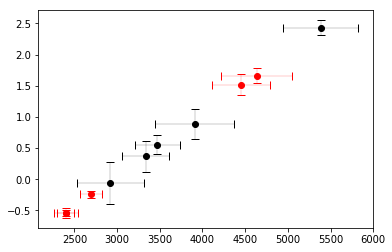

stat3
0 ADs are significantly different from WT using the Normalization to No AD
0 ADs are significantly different from WT using the Zscore Normalization to No AD
0 ADs are significantly different from WT using both
WT activity is 2400.073207
Empty DataFrame
Columns: [shortname, Activity_Mean_MSS18]
Index: []


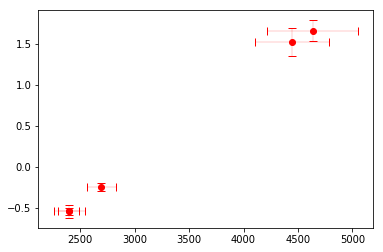

p65
0 ADs are significantly different from WT using the Normalization to No AD
0 ADs are significantly different from WT using the Zscore Normalization to No AD
0 ADs are significantly different from WT using both
WT activity is 2395.712207
Empty DataFrame
Columns: [shortname, Activity_Mean_MSS18]
Index: []


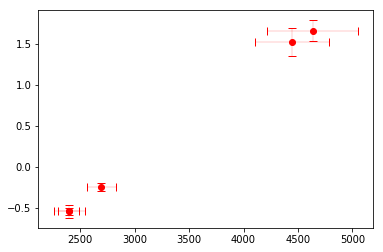

In [9]:
# which variants are only significantly different from WT in Z score space?
for AD in ADlist:
    print AD
    print '%i ADs are significantly different from WT using the Normalization to No AD' % sum((masterDF.SigDiff_NormToNoAD==True)&masterDF[AD])
    print '%i ADs are significantly different from WT using the Zscore Normalization to No AD' % sum((masterDF.SigDiff_Zscore==True)&masterDF[AD])
    indx = (masterDF.SigDiff_Zscore==True) &( masterDF.SigDiff_NormToNoAD==True) & masterDF[AD]
    print '%i ADs are significantly different from WT using both' % sum(indx==True)
    indx = (masterDF.SigDiff_Zscore==True) -( masterDF.SigDiff_NormToNoAD==True) & masterDF[AD]
#     indx = ( masterDF.SigDiff_NormToNoAD==True) & masterDF[AD]
    tempDF = masterDF[indx]
    tempDF = tempDF.sort_values(by=currentItem,ascending=0)
    print 'WT activity is %f'% WTname2currentItemDict[AD]
    print tempDF[['shortname',currentItem]]
#     print tempDF[['shortname',currentItem,currentSEM,'Zscore_Mean_MSS18','Zscore_SEM_MSS18']]
#     plt.scatter(tempDF[currentItem],tempDF.Zscore_Mean_MSS18)
    plt.errorbar(tempDF[currentItem],tempDF.Zscore_Mean_MSS18,xerr=tempDF[currentSEM],yerr=tempDF.Zscore_SEM_MSS18,fmt='o',capsize=4, elinewidth=.2,c='k')
    plt.errorbar(WTDF[currentItem],WTDF['Zscore_Mean_MSS18'], xerr=WTDF[currentSEM],yerr=WTDF['Zscore_SEM_MSS18'],fmt='ro',capsize=4, elinewidth=.2,c='k')
    plt.show()
    
    

#### Using the normalization to No AD
    CITED2_N	 41 sig diff  117 total
    Hif1-AD2_46	 9 sig diff  112 total
    vp16N_C	 37 sig diff  73 total
    stat3	 0 sig diff  111 total
    p65	 0 sig diff  109 total
    
#### using Z scores after correcting for No AD control
    CITED2_N	 50 sig diff  117 total
    Hif1-AD2_46	 22 sig diff  112 total
    vp16N_C	 42 sig diff  73 total
    stat3	 0 sig diff  111 total
    p65	 0 sig diff  109 total

### Correct the names of mutants that were not correctly designed by hand

In [10]:
Seq2NewNameDict ={
    'GSPGLPNGLLSGDEDFSSIADMDFSALLSQISS':'p65+GS',
    'RAAGQSMDESGAAAATSYDCEVNAPIQGSRNLLQGEELLRALDQVN':'killmotif_LPQL_A_plus2As',
    'RLLGQSMDESGAAAATSYDCEVNAPIQGSRNLLQGEELLRALDQVN':'killmotif_LPQL_A',
    'RAAGQSMDESGGGGGTSYDCEVNAPIQGSRNLLQGEELLRALDQVN':'killmotif_LPQL_G_plus2As',
    'PGAPNGAASGDEDFSSIADMDFSALLSQISS':'killmotif2',
    'PGLPNGLLSGDEDFSSIADMDASAAASQISS':'killmotif1'
    
}
for seq in Seq2NewNameDict.keys():
    print masterDF[indx].shortname
    indx = masterDF.ADseq==seq
    temp = masterDF.shortname
    temp[indx] = Seq2NewNameDict[seq]
    masterDF.shortname = temp
    print masterDF[indx].shortname

Series([], Name: shortname, dtype: object)
ADseq
PGLPNGLLSGDEDFSSIADMDASAAASQISS    killmotif1
Name: shortname, dtype: object
ADseq
PGLPNGLLSGDEDFSSIADMDASAAASQISS    killmotif1
Name: shortname, dtype: object
ADseq
RAAGQSMDESGAAAATSYDCEVNAPIQGSRNLLQGEELLRALDQVN    killmotif_LPQL_A_plus2As
Name: shortname, dtype: object
ADseq
RAAGQSMDESGAAAATSYDCEVNAPIQGSRNLLQGEELLRALDQVN    killmotif_LPQL_A_plus2As
Name: shortname, dtype: object
ADseq
GSPGLPNGLLSGDEDFSSIADMDFSALLSQISS    p65+GS
Name: shortname, dtype: object
ADseq
GSPGLPNGLLSGDEDFSSIADMDFSALLSQISS    p65+GS
Name: shortname, dtype: object
ADseq
PGAPNGAASGDEDFSSIADMDFSALLSQISS    killmotif2
Name: shortname, dtype: object
ADseq
PGAPNGAASGDEDFSSIADMDFSALLSQISS    killmotif2
Name: shortname, dtype: object
ADseq
RAAGQSMDESGGGGGTSYDCEVNAPIQGSRNLLQGEELLRALDQVN    killmotif_LPQL_G_plus2As
Name: shortname, dtype: object
ADseq
RAAGQSMDESGGGGGTSYDCEVNAPIQGSRNLLQGEELLRALDQVN    killmotif_LPQL_G_plus2As
Name: shortname, dtype: object
ADseq
RLLGQSMDE

### Correct the 'ADtype' indecies of the p65 L2Y variants that have an extra 2 AA at the start
The length discrepancy messes up some downstream analyses

In [11]:
print 'Before \n%i in the p65 column'% sum(masterDF.p65)
print '%i in the p65_Y2L column'% sum(masterDF.p65_L2Y)
Seqs =['GSPGAPNGAASGDEDFSSIADMDFSALLSQISS','GSPGLPNGLLSGDEDFSSIADMDFSALLSQISS','GSPGYPNGLLSGDEDFSSIADMDASAAASQISS']
for seq in Seqs:
    indx = masterDF.ADseq==seq
    temp_p65 = masterDF.p65
    temp_p65[indx] = 0
    temp_p65_Y2L = masterDF.p65_L2Y
    temp_p65_Y2L[indx]=1
    masterDF.p65 = temp_p65
    masterDF.p65_L2Y = temp_p65_Y2L
# indx = masterDF.p65

temp = masterDF[indx]
temp.ADseq
print 'After\n%i in the p65 column'% sum(masterDF.p65)
print '%i in the p65_Y2L column'% sum(masterDF.p65_L2Y)

Before 
109 in the p65 column
3 in the p65_Y2L column
After
106 in the p65 column
6 in the p65_Y2L column


### Correct the 'PerturbAromatics' and 'PerturbCharge' columns to be boolean

In [12]:
masterDF['PerturbAromatics']=(masterDF['PerturbAromatics']!=0)&(masterDF.shortname!='none')
masterDF['PerturbCharge'] =(masterDF['PerturbCharge']!=0)&(masterDF.shortname!='none')
masterDF['HandDesigned']=(masterDF.HandDesigned)&(masterDF.WT==False)

In [13]:
# summarize mutation types
Mutsets = ['PerturbCharge','PerturbAromatics','HandDesigned','Shuffle','WT']
totals =[]
for ad in ExtendedADlist:
    temp = 0
    print '\n'+ad
    indx = (masterDF[ad]==1)# &(masterDF[muttype]==1)
    totals.append(sum(indx))
    print '%s %i' %('Total',sum(indx))
    for muttype in Mutsets:
        indx = (masterDF[ad]==1) &(masterDF[muttype]==True)
        print '%s %i' %(muttype,sum(indx))
        temp+=sum(indx)
    print 'Sum of mut sets = %i'% temp
indx =(masterDF['PerturbCharge']==0)&(masterDF['PerturbAromatics']==0)&(masterDF['HandDesigned']==0)&(masterDF['Shuffle']==0)
masterDF[indx]
print '\nThere are %i variants in the library'% sum(totals)


CITED2_N
Total 117
PerturbCharge 53
PerturbAromatics 40
HandDesigned 17
Shuffle 6
WT 1
Sum of mut sets = 117

Hif1-AD2_46
Total 112
PerturbCharge 53
PerturbAromatics 28
HandDesigned 21
Shuffle 9
WT 1
Sum of mut sets = 112

vp16N_C
Total 73
PerturbCharge 31
PerturbAromatics 22
HandDesigned 10
Shuffle 9
WT 1
Sum of mut sets = 73

stat3
Total 111
PerturbCharge 55
PerturbAromatics 33
HandDesigned 16
Shuffle 6
WT 1
Sum of mut sets = 111

p65
Total 106
PerturbCharge 53
PerturbAromatics 33
HandDesigned 10
Shuffle 9
WT 1
Sum of mut sets = 106

p65_L2Y
Total 6
PerturbCharge 0
PerturbAromatics 0
HandDesigned 6
Shuffle 0
WT 0
Sum of mut sets = 6

There are 525 variants in the library


In [14]:
# add column to indicate the 'SuperCharge' variants
masterDF['Supercharge']= masterDF.apply(lambda row: 'supercharge' in row['shortname'],axis=1)


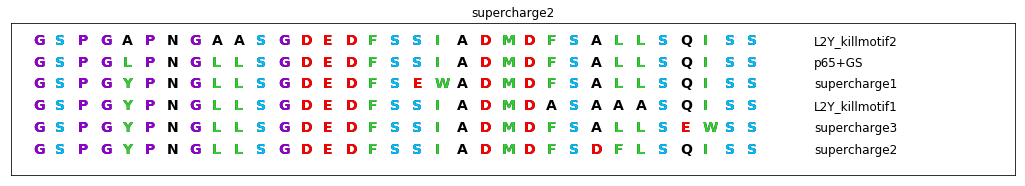

,ADseq,shortname
ADseq,,
GSPGAPNGAASGDEDFSSIADMDFSALLSQISS,GSPGAPNGAASGDEDFSSIADMDFSALLSQISS,L2Y_killmotif2
GSPGLPNGLLSGDEDFSSIADMDFSALLSQISS,GSPGLPNGLLSGDEDFSSIADMDFSALLSQISS,p65+GS
GSPGYPNGLLSGDEDFSEWADMDFSALLSQISS,GSPGYPNGLLSGDEDFSEWADMDFSALLSQISS,supercharge1
GSPGYPNGLLSGDEDFSSIADMDASAAASQISS,GSPGYPNGLLSGDEDFSSIADMDASAAASQISS,L2Y_killmotif1
GSPGYPNGLLSGDEDFSSIADMDFSALLSEWSS,GSPGYPNGLLSGDEDFSSIADMDFSALLSEWSS,supercharge3
GSPGYPNGLLSGDEDFSSIADMDFSDFLSQISS,GSPGYPNGLLSGDEDFSSIADMDFSDFLSQISS,supercharge2


In [15]:
def visualize_AAset_DF(AD_DF,AAsets,AAset_Labels, colorSets,colname='shortname'):
    fig3, axes = plt.subplots( figsize=(18,len(AD_DF)*.3+1))
    ypos = 0
    for j,entry in AD_DF.iterrows():
        AD = entry.ADseq
        for pos, ADaa in enumerate(AD):
            plt.text(pos,ypos, ADaa, color='k',fontsize=14, fontweight='bold')
        for i, aaList in enumerate(AAsets):
            for pos, ADaa in enumerate(AD):
                if ADaa in aaList:
                    plt.text(pos,ypos, ADaa, color=colorSets[i],fontsize=14, fontweight='bold')
        plt.text(pos+3,ypos,entry[colname],fontsize=12)
        ypos+=1
    plt.axis([-1, pos+12, ypos,-1])
    plt.xticks([]),    plt.yticks([])
    plt.title(entry.shortname)
#     plt.savefig('Figures/'+Folder+'MutantList.png')
    plt.show()
AAsets= [['D','E'],['W','L','F','Y','M','I'],['K','R'],['S','T'],['P','G']]
AAset_Labels = [ 'Negatives','Hyrdophobics','Positives','Phospho sites','Prolines & Glycines']
colorSets = ['red','limegreen','blue','deepskyblue','darkviolet']


indx = (masterDF.p65_L2Y)&(masterDF.HandDesigned)
tempDF =masterDF[indx]
visualize_AAset_DF(tempDF,AAsets,AAset_Labels, colorSets)
tempDF[['ADseq','shortname']]

# Add systematic name and hamming distance
20210409

In [16]:
#collapseAD boolean columns
WTname2seqDict.update({'p65_L2Y':'GSPGYPNGLLSGDEDFSSIADMDASAAASQISS'})
df = masterDF[['CITED2_N', 'stat3', 'Hif1-AD2_46','p65_L2Y', 'p65','vp16N_C']]
masterDF['ADid'] = df.idxmax(1).to_frame('ADid')
# make systematic names
SystematicName = []
Hamming = []
for j, row in masterDF.iterrows():#for each AD
    tempWT = WTname2seqDict[row.ADid]#find WT seq
    tempname = ''
    substitutions = []
    tempSeq = row.ADseq
    for i, aa in enumerate(tempSeq): # for each position
        if aa != tempWT[i]: # if mismatch
            coord = ADCoordinates[row.ADid][0]+i
            substitutions.append('%s%i%s'%(tempWT[i],coord,aa))
    tempname = ','.join(substitutions) # combine changes into a string
    SystematicName.append(tempname)
    Hamming.append(len(substitutions))
masterDF['SystematicName']=SystematicName
masterDF['Hamming']=Hamming
# masterDF[['SystematicName','shortname']]

# Calculate Omega for all the variants
WFY vs Acidics
WFYL vs Acidics

In [17]:
Kappa, Omega, Omega_WFY_DE, Omega_WFYL_DE  = [],[],[],[] #added 20170828

# Kappa and Omega are poorly defined if any set is <10% of the total sequence--skip those
for line in masterDF.ADseq: # This analysis leaves out the leading 'M' from the start codon
    thresh = np.ceil(0.1*len(line))
    if ((line.count('D')+line.count('E'))<thresh)|((line.count('K')+line.count('R'))<thresh):
        Kappa.append(np.nan)
    else:
        seq =  SequenceParameters(line)
        Kappa.append(seq.get_kappa()) # kappa
masterDF['Kappa']=Kappa

# Classic Omega is E,D,K,R,P
for line in masterDF.ADseq: # This analysis leaves out the leading 'M' from the start codon
    thresh = np.ceil(0.1*len(line))
    if (line.count('D')+line.count('E')+line.count('K')+line.count('R')+line.count('P'))<thresh:
        Omega.append(np.nan)
    else:
        seq =  SequenceParameters(line)
        Omega.append(seq.get_Omega()) # omega #added 20170828
masterDF['Omega']=Omega

for line in masterDF.ADseq: # This analysis leaves out the leading 'M' from the start codon
    thresh = np.ceil(0.1*len(line))
    if ((line.count('D')+line.count('E'))<thresh)|((line.count('W')+line.count('F')+line.count('Y'))<thresh):
        Omega_WFY_DE.append(np.nan)
    else:
        seq =  SequenceParameters(line)
        Omega_WFY_DE.append(seq.get_kappa_X(['W','F','Y'],['D','E']))
masterDF['Omega_WFY_DE']=Omega_WFY_DE

for line in masterDF.ADseq: # This analysis leaves out the leading 'M' from the start codon
    thresh = np.ceil(0.1*len(line))
    if ((line.count('D')+line.count('E'))<thresh)|((line.count('W')+line.count('F')+line.count('Y')+line.count('L'))<thresh):
        Omega_WFYL_DE.append(np.nan)
    else:
        seq =  SequenceParameters(line)
        Omega_WFYL_DE.append(seq.get_kappa_X(['W','F','Y','L'],['D','E']))
masterDF['Omega_WFYL_DE']=Omega_WFYL_DE


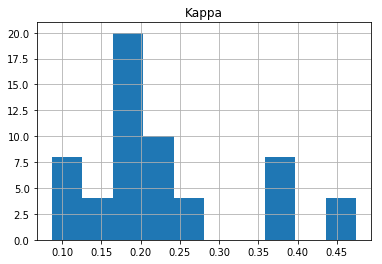

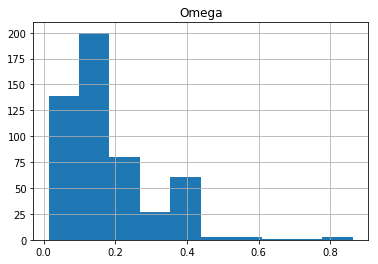

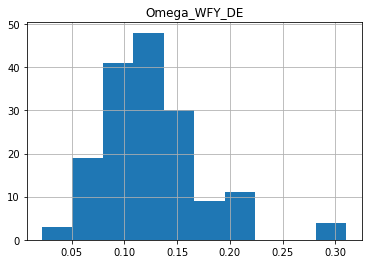

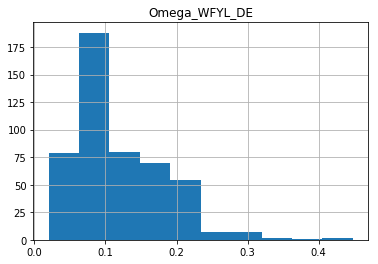

In [19]:
for col in ['Kappa', 'Omega', 'Omega_WFY_DE', 'Omega_WFYL_DE']:
    masterDF.hist(col)
    plt.show()



In [20]:
masterDF.to_pickle('pickleFiles/MSS18_MasterDF_afterProcessingStep2_20210722')
WTDF.to_pickle('pickleFiles/MSS18_WTDF_afterProcessingStep2_20210722')